In [25]:
import os
import re
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix

In [26]:
df = pd.read_csv("../../csv_files/yikyak_metadata.csv")

In [10]:
TEXT_COL = "text_clean"
LABEL_COL = "high_engagement"
# Set aside numeric features
NUM_COLS = [
     "text_length", "created_hour", "first_person_count", "second_person_count", "first_person_ratio", "second_person_ratio",
    "disagree_count",  "conflict_count",  "exclamations", "questions",  "vader_compound",
    "posts_prev_2h_all",
"rel_posts_prev_2h",
"burst_z_group",
"burst_flag_group",
]

use_cols = [TEXT_COL, LABEL_COL] + NUM_COLS
df_model = df[use_cols].dropna().copy()


In [11]:
# Replace infinities with NaN, then fill NaN
df_model[NUM_COLS] = df_model[NUM_COLS].replace([np.inf, -np.inf], np.nan)
df_model[NUM_COLS] = df_model[NUM_COLS].fillna(0)


In [12]:
X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].astype(int).values
y_test  = X_test_df[LABEL_COL].astype(int).values

tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_text = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test_text  = tfidf.transform(X_test_df[TEXT_COL])


In [13]:
X_train_num = csr_matrix(X_train_df[NUM_COLS].astype(float).values)
X_test_num  = csr_matrix(X_test_df[NUM_COLS].astype(float).values)

X_train = hstack([X_train_text, X_train_num])
X_test  = hstack([X_test_text, X_test_num])

In [14]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
pred = rf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))


Confusion matrix:
 [[3184  259]
 [ 296   86]]

Report:
               precision    recall  f1-score   support

           0      0.915     0.925     0.920      3443
           1      0.249     0.225     0.237       382

    accuracy                          0.855      3825
   macro avg      0.582     0.575     0.578      3825
weighted avg      0.848     0.855     0.852      3825



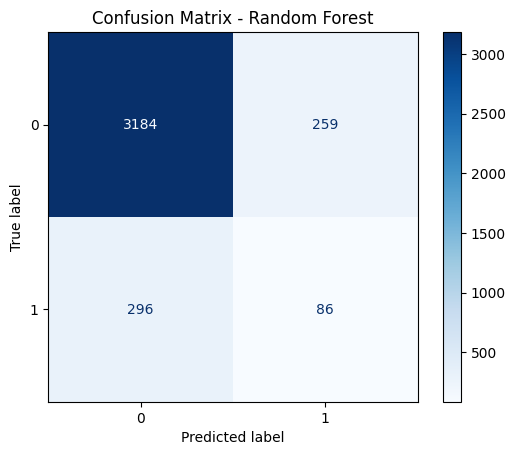

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    rf,
    X_test,
    y_test,
    cmap='Blues'
)
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",          # or "balanced_subsample"
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
pred = clf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))


Confusion matrix:
 [[3442    1]
 [ 382    0]]

Report:
               precision    recall  f1-score   support

           0      0.900     1.000     0.947      3443
           1      0.000     0.000     0.000       382

    accuracy                          0.900      3825
   macro avg      0.450     0.500     0.474      3825
weighted avg      0.810     0.900     0.853      3825



In [23]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [24]:
clf_pred = clf.predict(X_test)

print("Confusion matrix:\n", confusion_matrix(y_test, clf_pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))


Confusion matrix:
 [[3010  433]
 [ 252  130]]

Report:
               precision    recall  f1-score   support

           0      0.900     1.000     0.947      3443
           1      0.000     0.000     0.000       382

    accuracy                          0.900      3825
   macro avg      0.450     0.500     0.474      3825
weighted avg      0.810     0.900     0.853      3825



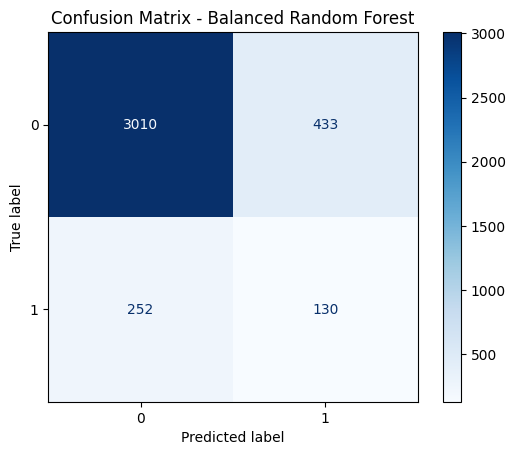

In [32]:
# Confusion Matrix (uses default decision boundary)
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    cmap='Blues'
)
plt.title('Confusion Matrix - Balanced Random Forest')
plt.show()

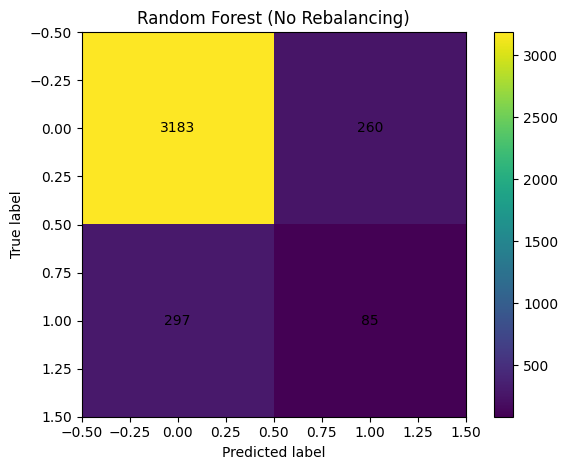

In [195]:
import matplotlib.pyplot as plt
# creating data vis
cm = confusion_matrix(y_test, pred)  # normal RF predictions

plt.figure()
plt.imshow(cm)
plt.title("Random Forest (No Rebalancing)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

# add numbers to cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


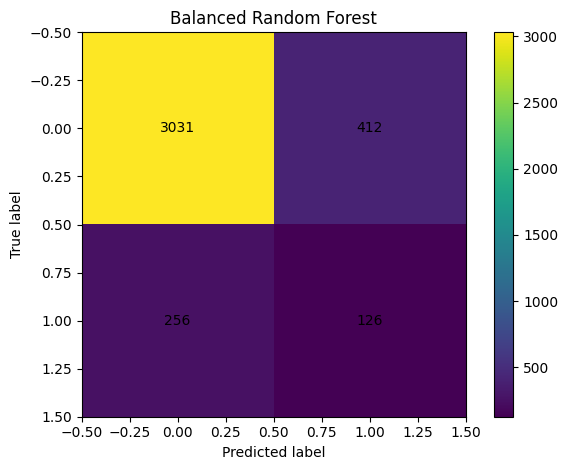

In [196]:
cm_bal = confusion_matrix(y_test, clf_pred)  # Balanced RF predictions

plt.figure()
plt.imshow(cm_bal)
plt.title("Balanced Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

for i in range(cm_bal.shape[0]):
    for j in range(cm_bal.shape[1]):
        plt.text(j, i, cm_bal[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


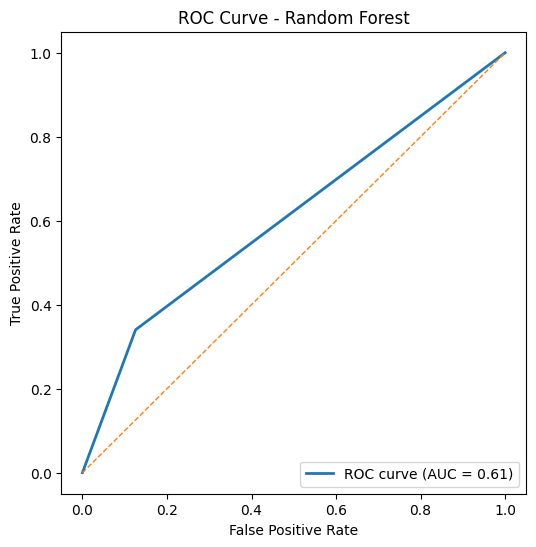

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Get decision scores (NOT probabilities)
y_scores = clf.predict(X_test)

# ROC curve + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()